## NeDF

In [68]:
# Import all the good stuff
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### Utilitary functions

In [69]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

In [70]:
def fov_to_focal_length(fov: float, width: int) -> float:
    """
    Convert field of view (FOV) to focal length.

    Args:
        fov (float): Field of view in degrees (horizontal).
        width (int): Image width in pixels.

    Returns:
        float: Focal length in pixels.
    """
    fov_tensor = torch.tensor(fov, dtype=torch.float32)
    focal_length = width / (2 * torch.tan(torch.deg2rad(fov_tensor / 2)))
    return focal_length

def pos_angle_to_tform_cam2world(camera_pos: torch.Tensor, camera_angle: torch.Tensor) -> torch.Tensor:
    """
    Create a transformation matrix from camera position and angles.

    Args:
        camera_pos (torch.Tensor): Camera position as (x, y, z).
        camera_angle (torch.Tensor): Camera angles as (pitch, yaw, roll) in degrees.

    Returns:
        torch.Tensor: 4x4 transformation matrix from camera to world.
    """
    pitch, yaw, roll = camera_angle

    # Define rotation matrices
    Rx = torch.tensor([
        [1, 0, 0],
        [0, torch.cos(pitch), -torch.sin(pitch)],
        [0, torch.sin(pitch), torch.cos(pitch)]
    ], dtype=torch.float32)

    Ry = torch.tensor([
        [torch.cos(yaw), 0, torch.sin(yaw)],
        [0, 1, 0],
        [-torch.sin(yaw), 0, torch.cos(yaw)]
    ], dtype=torch.float32)

    Rz = torch.tensor([
        [torch.cos(roll), -torch.sin(roll), 0],
        [torch.sin(roll), torch.cos(roll), 0],
        [0, 0, 1]
    ], dtype=torch.float32)

    # Combine rotation matrices
    rotation_matrix = Rz @ Ry @ Rx

    # Create a 4x4 transformation matrix
    tform_cam2world = torch.eye(4, dtype=torch.float32)
    tform_cam2world[:3, :3] = rotation_matrix
    tform_cam2world[:3, 3] = camera_pos

    return tform_cam2world

def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

### Network architecture

In [71]:
class VeryTinyNeDFModel(torch.nn.Module):
    r"""Define a "very tiny" NeDF model comprising three fully connected layers."""
    def __init__(self, filter_size=128, far_thresh=1000.0, L=10):
        self.L = L
        # self.input_dim = 3 + 2 * L * 3 # Due to positional encoding
        self.input_dim = 3 # Since we don't use it, just x,y,z
        super(VeryTinyNeDFModel, self).__init__()
        # Input layer (default: 3 + 2 * L * 3 -> 128 if positional encoding is enabled, 3 -> 128 otherwise)
        self.layer1 = torch.nn.Linear(self.input_dim, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 1) for predicting distance
        self.layer3 = torch.nn.Linear(filter_size, 1)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu
        self.far_thresh = far_thresh

    # Not convincing currently
    def positional_encoding(self, x):
        encoded = [x]
        for i in range(self.L):
            encoded.append(torch.sin(2**i * x))
            encoded.append(torch.cos(2**i * x))
        return torch.cat(encoded, dim=-1)

    def forward(self, x):
        # x = self.positional_encoding(x)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x) # Output is raw distance
        return torch.clamp(x, min=0.0, max=self.far_thresh) # Clamp output to prevent crazy / negative distances


### GPU vs CPU ?

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load input images, poses, intrinsics, etc.

In [81]:
DATA_PATH = "./data/robot_1"
CAMERAS_PATH = f"{DATA_PATH}/cameras_attributes.npz"
DEPTHS_PATH = f"{DATA_PATH}/depth"

FOV = 30.0
DEPTHMAP_SIZE_RESCALE = 0.25

# BASE DATASET STRUCTURE
BASE_CAMERA_LOCATION_ENTRY = "cameras_locations"
BASE_CAMERA_ANGLE_ENTRY = "cameras_angle"

# TARGET DATASET STRUCTURE
RAYS_ENTRY = "rays"
RAY_ORIGINS_ENTRY = "ray_origins"
RAY_DIRECTIONS_ENTRY = "ray_directions"
DEPTH_MAP_ENTRY = "depth_map"
CAMERA_POS_ENTRY = "camera_pos"
CAMERA_ANGLE_ENTRY = "camera_angle"


In [92]:
# Load camera transforms
cameras = np.load(CAMERAS_PATH)

# Initialize dataset
dataset = {}

print("Loading depth maps and generating rays...")
# Load depth maps
for filename in os.listdir(DEPTHS_PATH):
    # Extract the index from the filename
    index = re.search(r'\d+', filename)
    if index:
        index_value = int(index.group())

        # Ignore invalid entries
        angle_norm = np.linalg.norm(cameras[CAMERA_ANGLE_COLUMN][index_value])
        if angle_norm < 1 - 1e-6:
            print(f"- Skipping index {index_value} due to invalid angle norm: {angle_norm}")
            continue

        # Load the depth map
        depth_map_path = os.path.join(DEPTHS_PATH, filename)
        depth_map = cv2.imread(depth_map_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)        

        # Resize the depth map
        new_width = int(depth_map.shape[1] * DEPTHMAP_SIZE_RESCALE)
        new_height = int(depth_map.shape[0] * DEPTHMAP_SIZE_RESCALE)
        resized_depth_map = cv2.resize(depth_map, (new_width, new_height), interpolation=cv2.INTER_AREA)

        # Compute focal length from FOV
        focal_length = fov_to_focal_length(FOV, new_width)

        # Convert position and angle to transformation matrix
        camera_pos = torch.tensor(cameras[BASE_CAMERA_LOCATION_ENTRY][index_value], dtype=torch.float32)
        camera_angle = torch.tensor(cameras[BASE_CAMERA_ANGLE_ENTRY][index_value], dtype=torch.float32)
        tform_cam2world = pos_angle_to_tform_cam2world(camera_pos, camera_angle)

        # Generate ray bundle
        ray_origins, ray_directions = get_ray_bundle(new_height, new_width, focal_length, tform_cam2world)

        # Store in the dataset
        dataset[index_value] = {
            RAYS_ENTRY: {
                RAY_ORIGINS_ENTRY: ray_origins,
                RAY_DIRECTIONS_ENTRY: ray_directions
            },
            DEPTH_MAP_ENTRY: resized_depth_map,
            CAMERA_POS_ENTRY: camera_pos,
            CAMERA_ANGLE_ENTRY: camera_angle
        }


# Manually remove invalid entries
del dataset[1]
del dataset[2]
DATASET_SIZE = len(dataset)
print(f"Successfully generated {DATASET_SIZE} entries !")

# Near and far clipping thresholds for depth values
near_thresh = 0.01
far_thresh = 500.0

Loading depth maps and generating rays...
- Skipping index 11 due to invalid angle norm: 0.0
Successfully generated 29 entries !


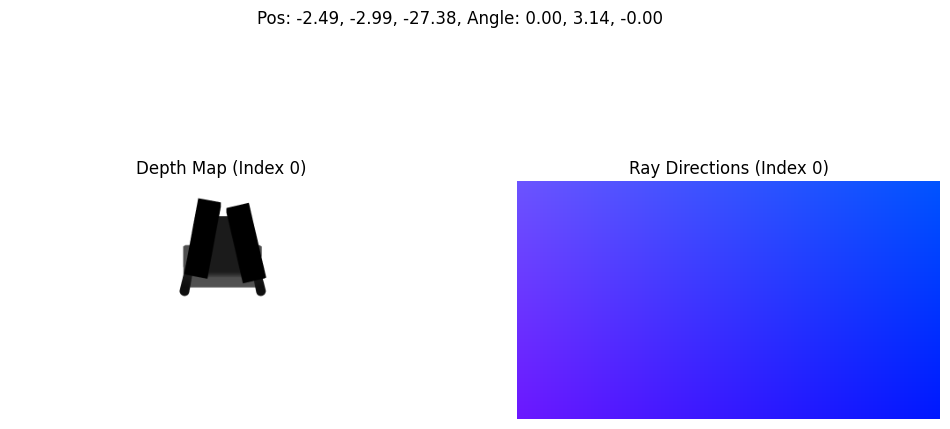

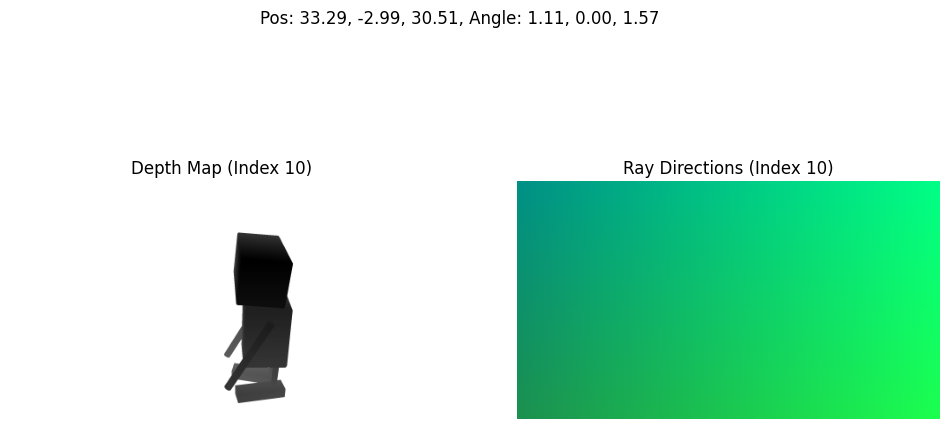

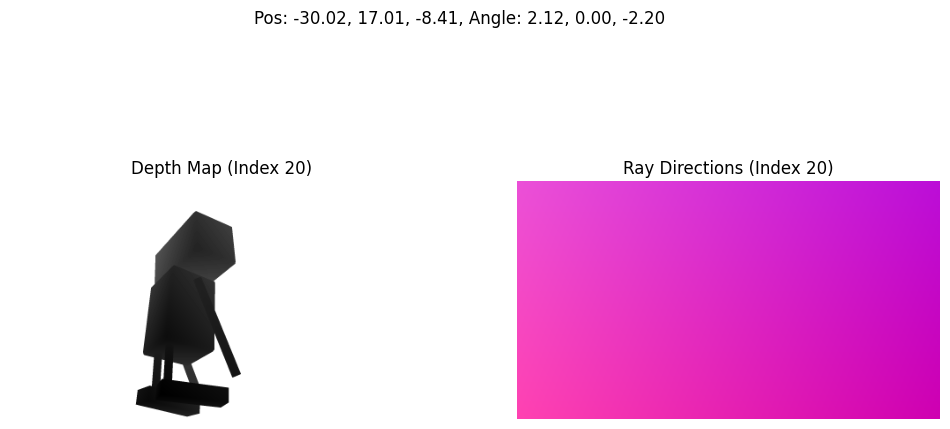

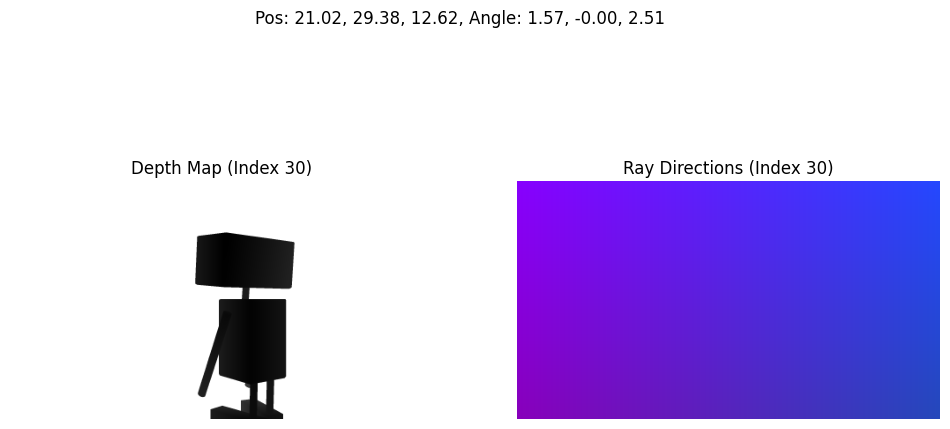

In [84]:
display_every = 10
for idx, data in dataset.items():
    if idx % display_every == 0:
        depth_image = data[DEPTH_MAP_ENTRY]
        ray_origins = data[RAYS_ENTRY][RAY_ORIGINS_ENTRY]
        ray_directions = data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY]
        camera_pos = data[CAMERA_POS_ENTRY]
        camera_angle = data[CAMERA_ANGLE_ENTRY]

        # Normalize rays for RGB visualization
        ray_rgb = (ray_directions - ray_directions.min()) / (ray_directions.max() - ray_directions.min())

        # Create a 2x1 plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Depth map
        axes[0].imshow(depth_image, cmap='gray')
        axes[0].set_title(f"Depth Map (Index {idx})")
        axes[0].axis('off')

        # Ray directions as RGB
        axes[1].imshow(ray_rgb.numpy())
        axes[1].set_title(f"Ray Directions (Index {idx})")
        axes[1].axis('off')

        # plt.suptitle(f"Camera Pos: {camera_pos}, Angle: {camera_angle}")
        # Format the camera angle to two decimal places
        formatted_angle = ', '.join([f"{angle:.2f}" for angle in camera_angle])
        formatted_pos = ', '.join([f"{pos:.2f}" for pos in camera_pos])

        # Update the plot title
        plt.suptitle(f"Pos: {formatted_pos}, Angle: {formatted_angle}")
        plt.show()

### Train !

This method renders a depth map using the model's predictions to dynamically adjust step size during ray marching.

In [85]:
def render_depth_sphere_tracing(
    distance_field_model: torch.nn.Module,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    depth_map: torch.Tensor,
    near_thresh: float,
    max_iterations: int = 50
) -> torch.Tensor:

    # Create a tensor to track active rays
    active_mask = torch.ones_like(depth_map, dtype=torch.bool)

    # Predicted depth map
    dstTravelled = torch.full_like(depth_map, 0, requires_grad=True)
    steps = torch.zeros_like(active_mask, dtype=torch.float32)
    
    all_query_points = []
    all_predicted_distances = []

    for i in range(max_iterations):
        # Stop if no active rays remain
        if not torch.any(active_mask):
            break
        
        # Compute the query points
        query_points = ray_origins + ray_directions * dstTravelled[..., None]
        query_points.requires_grad_()
        
        # Predict distances using the model
        predicted_distances = distance_field_model(query_points).squeeze(-1)

        # Increment the steps for active rays
        steps = torch.where(active_mask, steps + 1, steps)

        # Mask for rays that are within the surface threshold or exceeding far_thresh
        hit_mask = ((predicted_distances < near_thresh) | (dstTravelled >= depth_map)) & active_mask

        # Store active query points and predictions
        all_query_points.append(query_points[~hit_mask])
        all_predicted_distances.append(predicted_distances[~hit_mask])

        # Update active mask to deactivate rays that hit
        active_mask = active_mask & ~hit_mask
        
        # Update the depth map only for rays that have hit
        dstTravelled = torch.where(active_mask, dstTravelled + predicted_distances, dstTravelled)

    # Concatenate query points and distances
    all_query_points = torch.cat(all_query_points, dim=0)
    all_predicted_distances = torch.cat(all_predicted_distances, dim=0)

    return dstTravelled, steps, all_query_points, all_predicted_distances

In [86]:
def compute_gradients(model, query_points, eps=1e-4, sample_ratio=0.1):
    """
    Computes numerical gradients of SDF using finite differences.

    Args:
    - model: The implicit function.
    - query_points: Tensor of shape [N, 3], query points.
    - eps: Small step for finite differences.
    - sample_ratio: Fraction of points to sample for gradient computation.

    Returns:
    - gradients: Tensor of shape [sampled_N, 3], computed gradients.
    """
    N = query_points.shape[0]
    device = query_points.device

    # Randomly sample query points
    nb_samples = min(int(N * sample_ratio), 5000)
    sampled_indices = torch.randperm(N, device=device)[:nb_samples]
    sampled_points = query_points[sampled_indices]

    # Allocate memory for gradients
    gradients = torch.zeros_like(sampled_points, device=device)

    for i in range(3):  # Compute gradient w.r.t x, y, z
        offset = torch.zeros_like(sampled_points, device=device)
        offset[:, i] = eps

        forward_points = sampled_points + offset
        backward_points = sampled_points - offset

        forward_sdf = model(forward_points).squeeze(-1)
        backward_sdf = model(backward_points).squeeze(-1)

        # Central finite difference
        gradients[:, i] = (forward_sdf - backward_sdf) / (2 * eps)

    return gradients

def compute_eikonal_loss(gradients):
    """
    Computes the Eikonal loss using the computed gradients.

    Args:
    - gradients (torch.Tensor): Tensor of shape [N, 3] containing the gradients of SDF predictions.

    Returns:
    - loss (torch.Tensor): Computed Eikonal loss.
    """
    # ||grad|| should be close to 1, compute the deviation from 1
    loss = torch.mean(torch.abs(torch.norm(gradients, dim=-1) - 1))
    return loss

And now the training loop.

In [94]:
DISPLAY_EVERY = 1

# Define hyperparameters
num_epochs = 10
batch_size = DATASET_SIZE
lr = 1e-4
L = 10

# Model and optimizer
model = VeryTinyNeDFModel(L=L).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

depth_maps = []
eikonal_penalty_weight = 5

# Create DataLoader
train_loader = DataLoader(list(dataset.items()), batch_size=batch_size, shuffle=True)

# Training Loop
depth_maps = []
eikonal_penalty_weight = 5

for epoch in range(num_epochs):
    total_loss = 0
    for idx, (index, data) in enumerate(train_loader):
        # Correctly extract data from the dataset structure
        target_depth = torch.tensor(data[DEPTH_MAP_ENTRY], dtype=torch.float32).to(device)
        ray_origins = torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32).to(device)
        ray_directions = torch.tensor(data[RAYS_ENTRY][RAY_DIRECTIONS_ENTRY], dtype=torch.float32).to(device)

        # Render depth using sphere tracing
        depth_predicted, steps, query_points, query_results = render_depth_sphere_tracing(
            model, ray_origins, ray_directions, target_depth, near_thresh
        )

        # Compute Eikonal loss
        gradients = compute_gradients(model, query_points)
        eikonal_loss = compute_eikonal_loss(gradients)

        # Compute MSE depth loss
        depth_loss = torch.nn.functional.mse_loss(depth_predicted, target_depth)

        # Total loss
        loss = depth_loss + eikonal_penalty_weight * eikonal_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Display progress
        if idx % DISPLAY_EVERY == 0:
            print(f"Epoch {epoch}, Batch {idx} - Loss: {loss.item()} - Eikonal Loss: {eikonal_loss.item()}")

            # Save depth map visualization
            depth_img = depth_predicted.detach().cpu().numpy()
            depth_img_normalized = (depth_img - depth_img.min()) / (depth_img.max() - depth_img.min()) * 255.0
            depth_maps.append(depth_img_normalized.astype(np.uint8))

    print(f"Epoch {epoch} - Total Loss: {total_loss / len(train_loader)}")

C:\Users\Alex\AppData\Local\Temp\ipykernel_26972\3580885009.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_depth = torch.tensor(data[DEPTH_MAP_ENTRY], dtype=torch.float32).to(device)
C:\Users\Alex\AppData\Local\Temp\ipykernel_26972\3580885009.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_origins = torch.tensor(data[RAYS_ENTRY][RAY_ORIGINS_ENTRY], dtype=torch.float32).to(device)
C:\Users\Alex\AppData\Local\Temp\ipykernel_26972\3580885009.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ray_directions = torch.ten

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.79 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 9.63 GiB is allocated by PyTorch, and 1.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Save Training Video
output_file = "depth_map_training.mp4"
height, width = depth_maps[0].shape
video_writer = cv2.VideoWriter(
    output_file, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height), isColor=True
)

for depth_map in depth_maps:
    frame = np.stack([depth_map] * 3, axis=-1)
    video_writer.write(frame)

video_writer.release()
print(f"Training video saved as {output_file}")